In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    file_name = 'Task_5.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")

    print(path_to_file)

    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
./gdrive/MyDrive/URABNA2/
/content/gdrive/MyDrive/URABNA2


In [ ]:
pip install osmnx==0.16.2

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
import numpy as np
import pandas as pd
import osmnx as ox
from shapely.geometry import Polygon
from shapely.geometry import shape
import json
import os
import time
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from collections import defaultdict
%matplotlib inline

pd.set_option('display.max_columns', None)

In [ ]:
def getMinMax(xMax, yMax, xMin, yMin, bFirst, xLong, yLat):
    # return the min, max of x, y coord
    
    if bFirst:
        xMin = xMax = xLong
        yMin = yMax = yLat
        bFirst      = False
    else:
        if xLong > xMin:
            xMin = xLong
        elif xLong < xMax:
            xMax = xLong

        if yLat < yMin:
            yMin = yLat
        elif yLat > yMax:
            yMax = yLat
                    
    return xMax, yMax, xMin, yMin, bFirst

# Task 5: Plot top 5 road segments most traversed

In [ ]:
portoNodes = gpd.read_file('./portoNetCity/nodes.shp')
portoEdges = gpd.read_file('./portoNetCity/edges.shp')

In [ ]:
dfMapped = pd.read_csv('./data/matchedMaps.csv')

In [ ]:
def removeLineStringMgeom(string):

  string = string[11: -1] # remove LINESTRING & last bracket
  listOfCoords = []
  
  for elem in string.split(','):
      xLong, yLat = elem.split()
      listOfCoords.append((float(xLong), float(yLat))) # tuple of x, y coords
          
  return listOfCoords

In [ ]:
def removeLineStringGeometry(string):

  string = string.wkt
  string = string[12: -1] # remove LINESTRING & last bracket
  listOfCoords = []
  
  for elem in string.split(','):
      xLong, yLat = elem.split()
      listOfCoords.append((float(xLong), float(yLat))) # tuple of x, y coords
          
  return listOfCoords

In [ ]:
def pathInfo(path): ### method to get information of path from road network

    paths = portoEdges.loc[path, 'geometry']
    points = removeLineStringGeometry(paths)
    distance = 0

    if len(points) > 1:
        for i in range(len(points)-1):
            x2 = points[i+1][0]
            x1 = points[i][0]
            y2 = points[i+1][1]
            y1 = points[i][1]
            dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2) ### pythagoras theorem to find distance  
            distance += dist  

    distance = round(distance, 7)

    return (portoEdges.loc[path, 'osmid'], int(portoEdges.loc[path, 'u']), int(portoEdges.loc[path, 'v']), distance)

In [ ]:
def generateId(cleanedMapped): 

    uniquePathId = dict()
    uvdToId = dict()
    pathsWithSameID = dict()

    for entry in cleanedMapped:
        cpath = entry['cpath']
        opath = entry['opath']
        for paths in cpath+opath:
            if not paths in uniquePathId:
                osmid, u, v, d = pathInfo(paths)
                uvd = (min(u,v), max(u,v), d)
                if uvd not in uvdToId:
                    pathsWithSameID[len(uvdToId)] = []
                    uvdToId[uvd] = len(uvdToId)
                ID = uvdToId[uvd]
                pathsWithSameID[ID].append(paths)
                uniquePathId[paths] = (ID, osmid, u, v, d)

    return uniquePathId, pathsWithSameID

In [ ]:
def fiveMostTraversed(cleanedMapped):

    roadCpathFreqeuncy = defaultdict(int)
    for traj in cleanedMapped:
        cPathId = []
        repeatCPathId = [uniquePathId[cPath][0] for cPath in traj['cpath']]

        # Remove consecutive cpaths to avoid double count since consecutive cpaths indicates that the taxi have not finish travelling the road segment
        for i in repeatCPathId:
            if len(cPathId) == 0 or i != cPathId[-1]:
                cPathId.append(i)

        for Id in cPathId:
            roadCpathFreqeuncy[Id] += 1

    sortedCPathFrequency = sorted(roadCpathFreqeuncy.items(), key=lambda x: x[1], reverse=True)
    fiveMostTraversed = []

    for i in range(5):
        roadUniqueId = sortedCPathFrequency[i][0]
        paths = (pathsWithSameID[roadUniqueId])
        fiveMostTraversed.append((paths, roadCpathFreqeuncy[Id]))

    return fiveMostTraversed

In [ ]:
cleanedMapped = []
count = 0
for n in range(len(dfMapped)):
    if len(eval(dfMapped['opath'][n])) < 2 or len(eval(dfMapped['cpath'][n])) < 2:
        count += 1
        continue
    cleanedMapped.append(dict(
        t_number=n+1, cpath=eval(dfMapped['cpath'][n]), opath=eval(dfMapped['opath'][n]), 
        offset=eval(dfMapped['offset'][n]), length=eval(dfMapped['length'][n]),
        spdist=eval(dfMapped['spdist'][n]), mgeom=removeLineStringMgeom(dfMapped['mgeom'][n])
        ))
print('Empty entries: '+ str(count))

Empty entries: 86


In [ ]:
# Generate a pair of dictionaries: cpath/opath to unique road ID and vice versa
uniquePathId, pathsWithSameID = generateId(cleanedMapped)

In [ ]:
# Find boundary points
fiveMostTraversedRoads = fiveMostTraversed(cleanedMapped)

xMin = 0
xMax = 0
yMin = 0
yMax = 0
bFirst = True

for road in fiveMostTraversedRoads:
  roadCoords = removeLineStringGeometry(portoEdges.loc[road[0][0],'geometry'])

  for i in roadCoords:
    tmpX = i[0]
    tmpY = i[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
No handles with labels found to put in legend.


   Duration 6.439971685409546 seconds


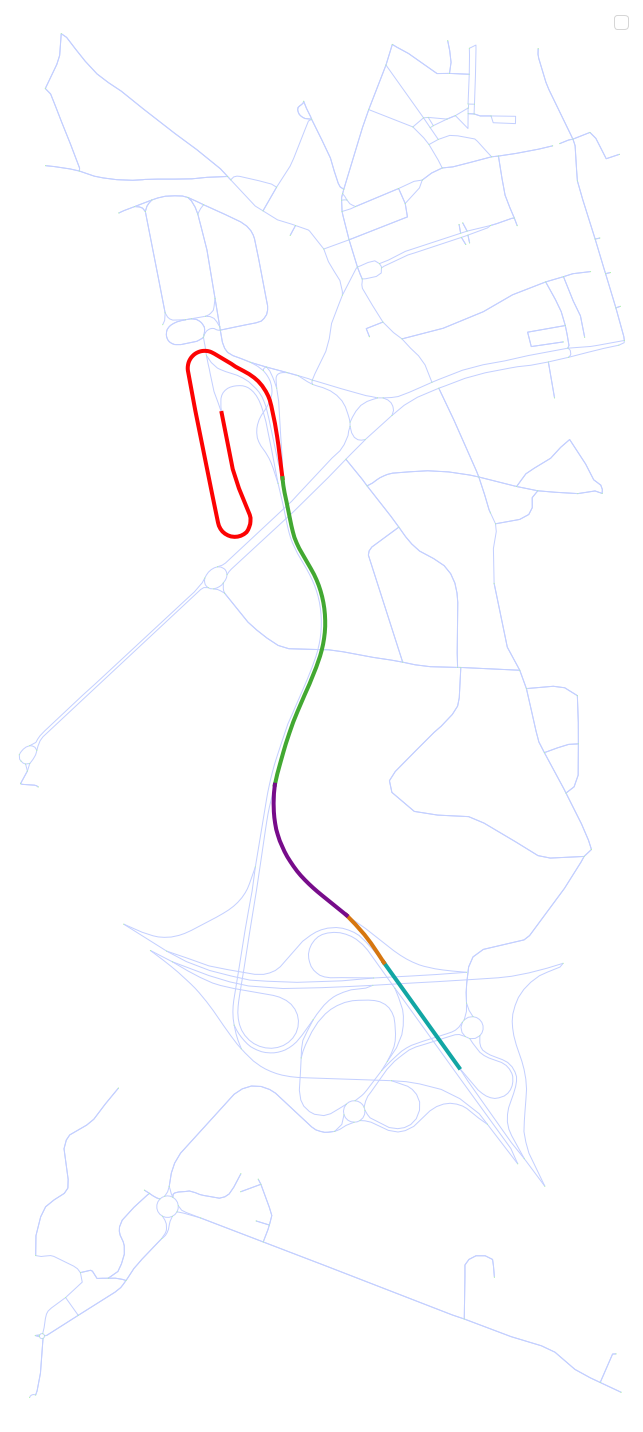

In [ ]:
# Plot five most traversed road segments
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
colorFive = ['#FC0303','#42A832','#11A6A4','#D6760F','#770C8A']
colorSelect = 0
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

for road in fiveMostTraversedRoads:
  roadCoords = removeLineStringGeometry(portoEdges.loc[road[0][0],'geometry'])
  ax.plot([i[0] for i in roadCoords], [i[1] for i in roadCoords], color = colorFive[colorSelect], linewidth=4)
  colorSelect += 1

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./mapPlots/5MostTraversed.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))

In [ ]:
roadName1 = portoEdges.loc[fiveMostTraversedRoads[0][0][0], "name"] 
roadName2 = portoEdges.loc[fiveMostTraversedRoads[1][0][0], "name"] 
roadName3 = portoEdges.loc[fiveMostTraversedRoads[2][0][0], "name"] 
roadName4 = portoEdges.loc[fiveMostTraversedRoads[3][0][0], "name"] 
roadName5 = portoEdges.loc[fiveMostTraversedRoads[4][0][0], "name"] 

print(roadName1)
print(roadName2)
print(roadName3)
print(roadName4)
print(roadName5)

Partidas
None
Via Regional Interior
None
None


# Task 5: Plot top 5 road segments with largest average travelling time in one plot

In [ ]:
def fiveLargestTime(cleanedMapped):

    uniqueIdTravelTime = defaultdict(list)

    for traj in cleanedMapped:
        cPathIdPointer = 0
        cPathId = []
        repeatCPathId = [uniquePathId[cPath][0] for cPath in traj['cpath']]

        for i in repeatCPathId: #remove consecutive cPaths to avoid double count
            if len(cPathId) == 0 or i != cPathId[-1]:
                cPathId.append(i)

        previousOPath = uniquePathId[traj['opath'][0]][0]

        for oPathPointer in range(1, len(traj['opath'])):
            currentOPath = uniquePathId[traj['opath'][oPathPointer]][0]

            # checks for 2 GPS points whether they are on the same road segment or on different road segments
            if previousOPath == currentOPath: 
                if traj['spdist'][oPathPointer] > 1e-7:
                    uniqueIdTravelTime[currentOPath].append((15, traj['spdist'][oPathPointer])) # 15 refers to the 15 seconds needed to travel between 2 gps points

            # if the 2 GPS points are on different road segments, then check cpath for the road segments traversed between the 2 GPS points
            else: 
                cPathList = []
                cPathDistList = []
                currentCPath = cPathId[cPathIdPointer]    

                # for the first road segment, the distance is = (distance of road)- (offset)          
                currentCPathDistTravelled = uniquePathId[traj['opath'][oPathPointer-1]][4] - traj['offset'][oPathPointer-1] 
                
                if currentCPathDistTravelled > 1e-7:
                    cPathList.append(currentCPath)
                    cPathDistList.append(currentCPathDistTravelled) 
                
                cPathIdPointer += 1
                currentCPath = cPathId[cPathIdPointer]

                # go through all road segments between the 2 GPS points
                while currentCPath != currentOPath:
                    cPathList.append(currentCPath)
                    cPathDistList.append(uniquePathId[traj['cpath'][cPathIdPointer]][4])
                    cPathIdPointer += 1
                    currentCPath = cPathId[cPathIdPointer]

                # for the last road segment, the distance is = (offset)
                if traj['offset'][oPathPointer] > 1e-7:
                    cPathList.append(currentCPath)
                    cPathDistList.append(traj['offset'][oPathPointer]) 

                totalDistBtwn2Gps = sum(cPathDistList)

                # as stated on Kaggle, the time between 2 GPS points is 15 seconds, thus we assume constant travelling speed and divide the 15seconds according to distance travelled on each road segment.
                cPathTimeList = [15/totalDistBtwn2Gps * i for i in cPathDistList]

                for cPath, time, distance in zip(*(cPathList, cPathTimeList, cPathDistList)):
                    uniqueIdTravelTime[cPath].append((time,distance))
                previousOPath = currentOPath
    
    # Since roads that are traversed more will have larger travelling time, we need to find the AVERAGE travelling time instead
    averageDuration = defaultdict(int)
    sortedDuration = defaultdict(int)

    for id, timeDistance in uniqueIdTravelTime.items():
      path = pathsWithSameID[id][0]
      distanceOfEntireRoad = uniquePathId[path][4]
      frequency = 0
      totalTimePerDist = 0

      for i in timeDistance:
        frequency += 1
        timePerDist = i[0]/i[1]
        totalTimePerDist += timePerDist

      averageTimePerDist = totalTimePerDist / frequency
      averageDuration[id] += averageTimePerDist * distanceOfEntireRoad


    sortedDuration = sorted(averageDuration.items(), key=lambda x: x[1], reverse=True)
    fiveMostTime = []

    for i in range(5):
        roadUniqueId = sortedDuration[i][0]
        paths = (pathsWithSameID[roadUniqueId])
        fiveMostTime.append((paths, sortedDuration[i][1]))

    return fiveMostTime

In [ ]:
fiveLongestTime = fiveLargestTime(cleanedMapped)

In [ ]:
roadName1 = portoEdges.loc[fiveLongestTime[0][0][0], "name"] 
roadName2 = portoEdges.loc[fiveLongestTime[1][0][0], "name"] 
roadName3 = portoEdges.loc[fiveLongestTime[2][0][0], "name"] 
roadName4 = portoEdges.loc[fiveLongestTime[3][0][0], "name"] 
roadName5 = portoEdges.loc[fiveLongestTime[4][0][0], "name"] 

print(roadName1)
print(roadName2)
print(roadName3)
print(roadName4)
print(roadName5)

Rua do Carriçal
Avenida Doutor Óscar Lopes
None
['Avenida Gustavo Eiffel', 'Avenida de Paiva Couceiro']
Rua da Prelada


In [ ]:
x_min = 0
x_max = 0
y_min = 0
y_max = 0
bFirst = True

for road in fiveLongestTime:
  roadCoords = removeLineStringGeometry(portoEdges.loc[road[0][0],'geometry'])

  for i in roadCoords:
    tmpX = i[0]
    tmpY = i[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
No handles with labels found to put in legend.


   Duration 12.956295490264893 seconds


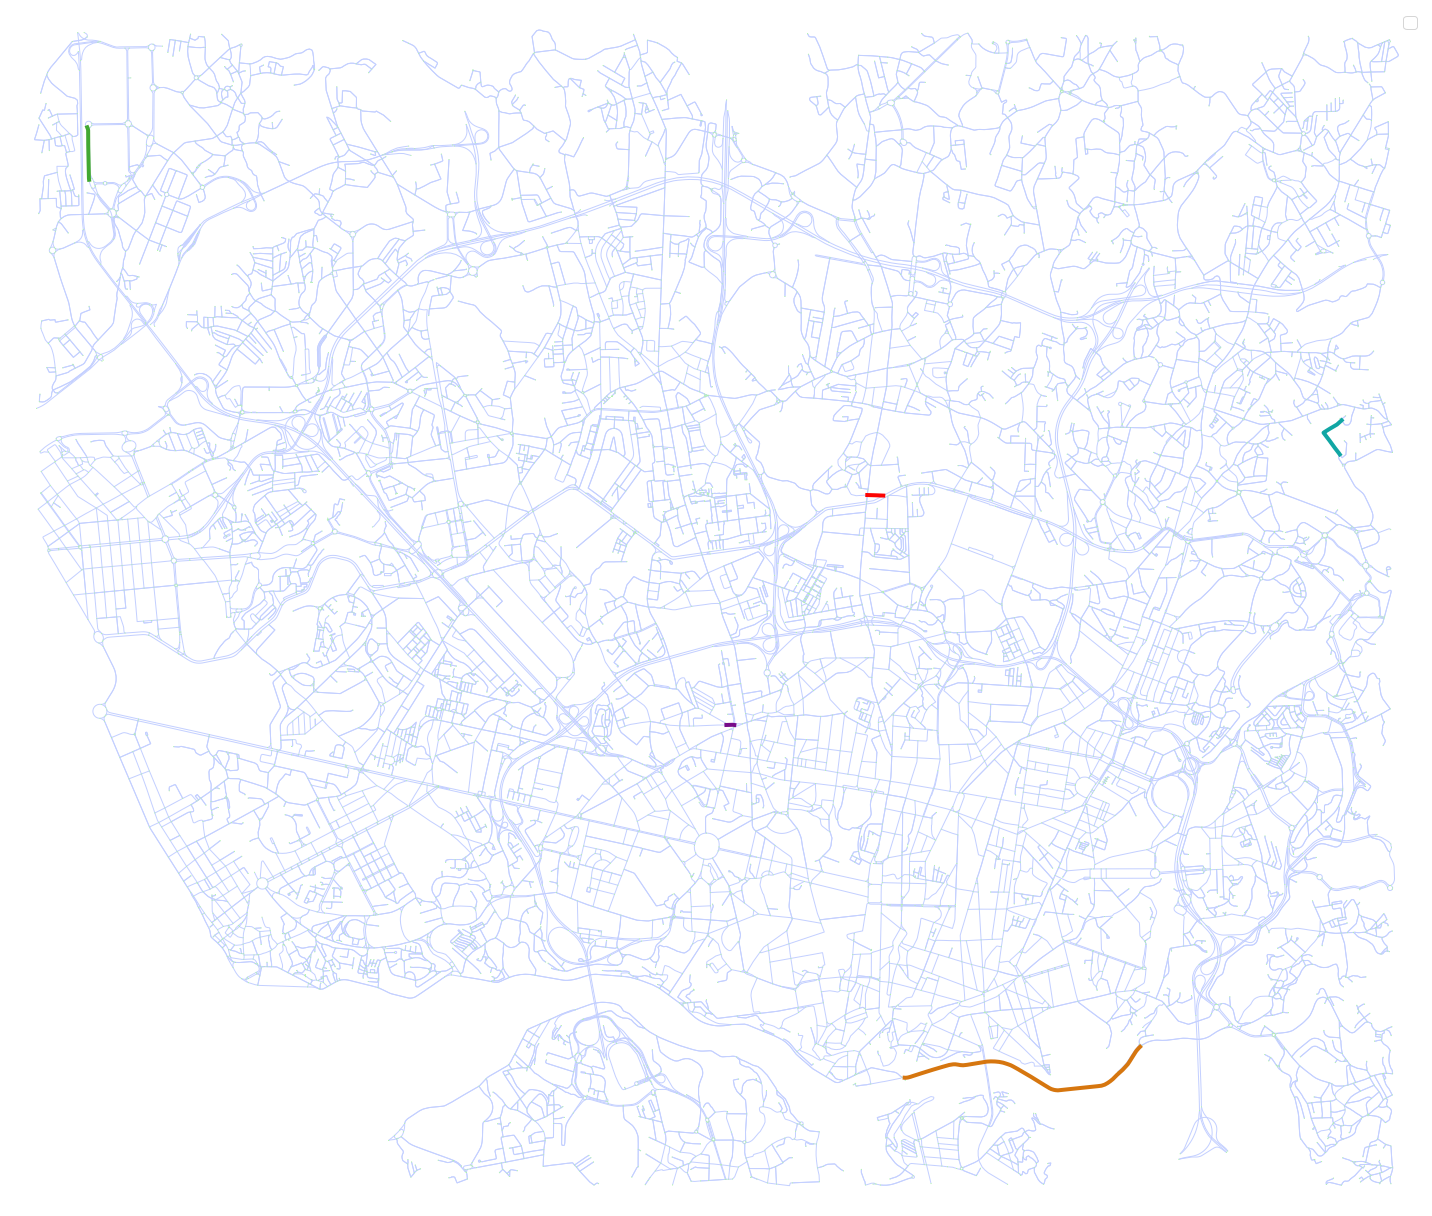

In [ ]:
# Plot five road segments with largest average travelling time
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
colorFive = ['#FC0303','#42A832','#11A6A4','#D6760F','#770C8A']
colorSelect = 0
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

for road in fiveLongestTime:
  roadCoords = removeLineStringGeometry(portoEdges.loc[road[0][0],'geometry'])
  ax.plot([i[0] for i in roadCoords], [i[1] for i in roadCoords], color = colorFive[colorSelect], linewidth=4)
  colorSelect += 1

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./mapPlots/5LargestTimeOnePlot.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))

# Task 5: Plot top 5 road segments with largest average travelling time separately (1st)


/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
No handles with labels found to put in legend.


   Duration 6.254928827285767 seconds
Rua do Carriçal


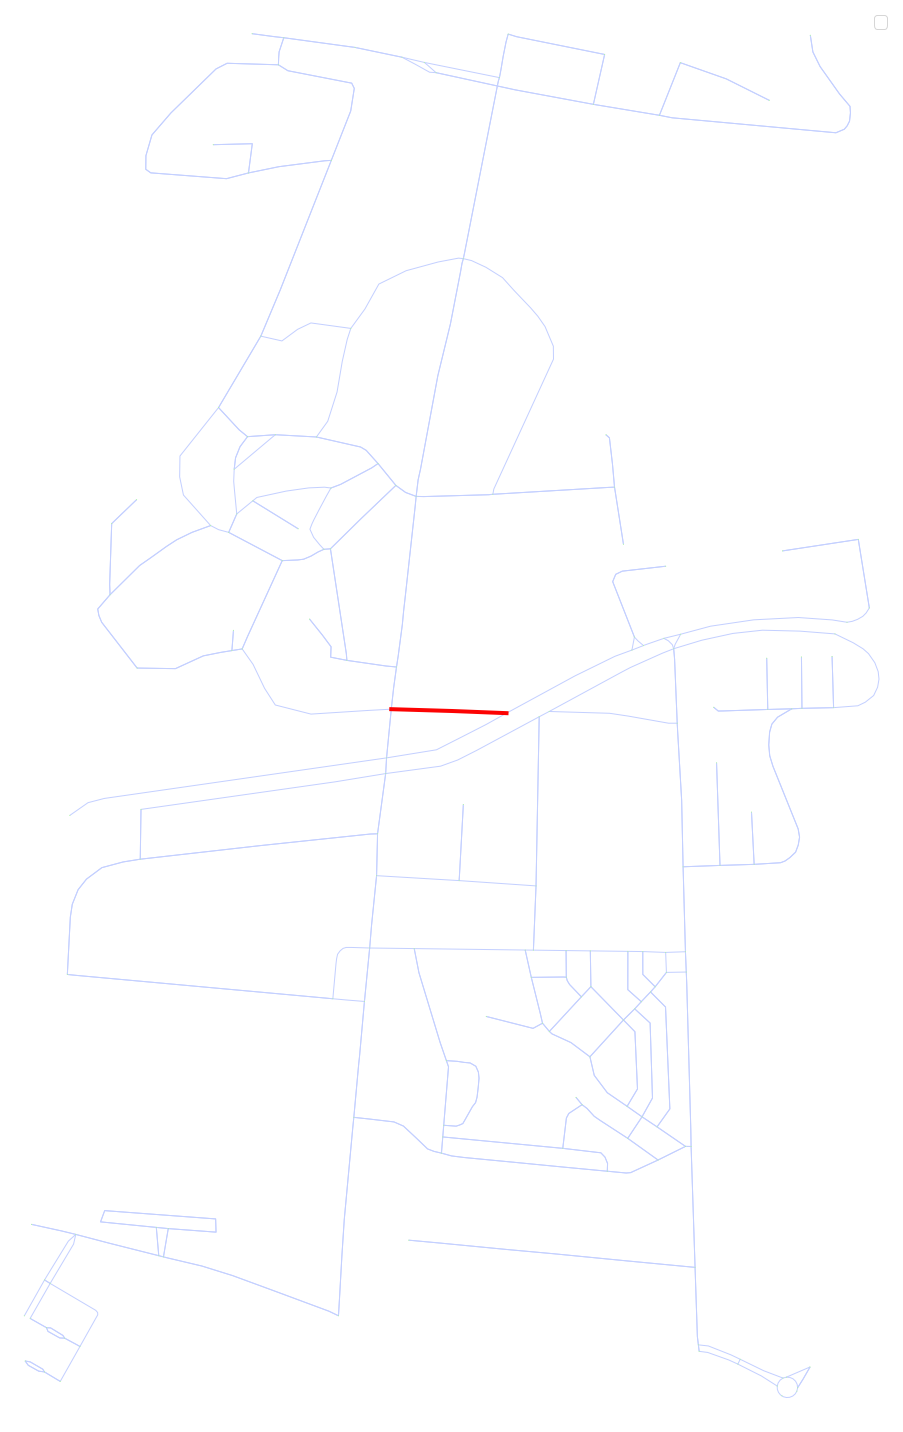

In [ ]:
# Plot 1st road segement

x_min = 0
x_max = 0
y_min = 0
y_max = 0
bFirst = True

roadCoords = removeLineStringGeometry(portoEdges.loc[fiveLongestTime[0][0][0],'geometry'])

for i in roadCoords:
  tmpX = i[0]
  tmpY = i[1]
  xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

# Plot five most traversed road segments
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot([i[0] for i in roadCoords], [i[1] for i in roadCoords], color = '#FC0303', linewidth=4)

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./mapPlots/5LargestTimeFirst.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))

# Print Road Name
roadName = portoEdges.loc[fiveLongestTime[0][0][0], "name"]
print(roadName)

# Task 5: Plot top 5 road segments with largest average travelling time separately (2nd)

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
No handles with labels found to put in legend.


   Duration 5.530060291290283 seconds
Avenida Doutor Óscar Lopes


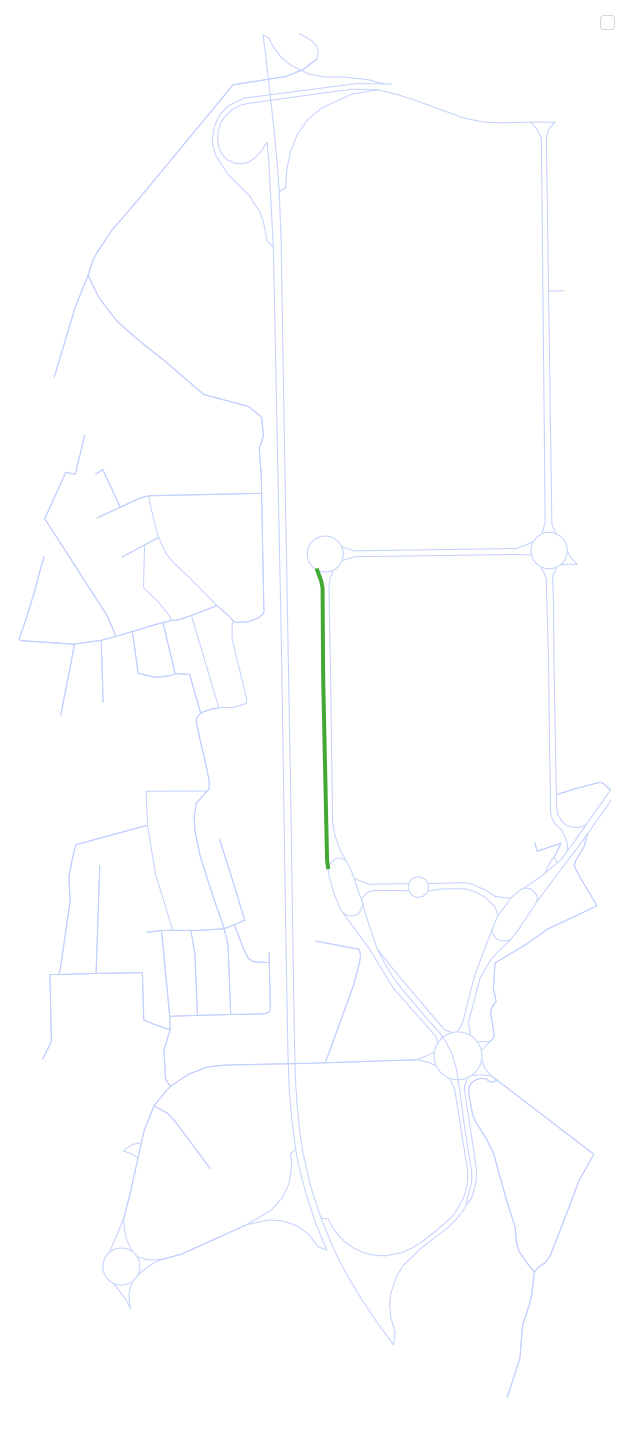

In [ ]:
# Plot 2nd road segement

x_min = 0
x_max = 0
y_min = 0
y_max = 0
bFirst = True

roadCoords = removeLineStringGeometry(portoEdges.loc[fiveLongestTime[1][0][0],'geometry'])

for i in roadCoords:
  tmpX = i[0]
  tmpY = i[1]
  xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

# Plot five most traversed road segments
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot([i[0] for i in roadCoords], [i[1] for i in roadCoords], color = '#42A832', linewidth=4)

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./mapPlots/5LargestTimeSecond.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))

# Print Road Name
roadName = portoEdges.loc[fiveLongestTime[1][0][0], "name"]
print(roadName)

# Task 5: Plot top 5 road segments with largest average travelling time separately (3rd)

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
No handles with labels found to put in legend.


   Duration 5.495814800262451 seconds
None


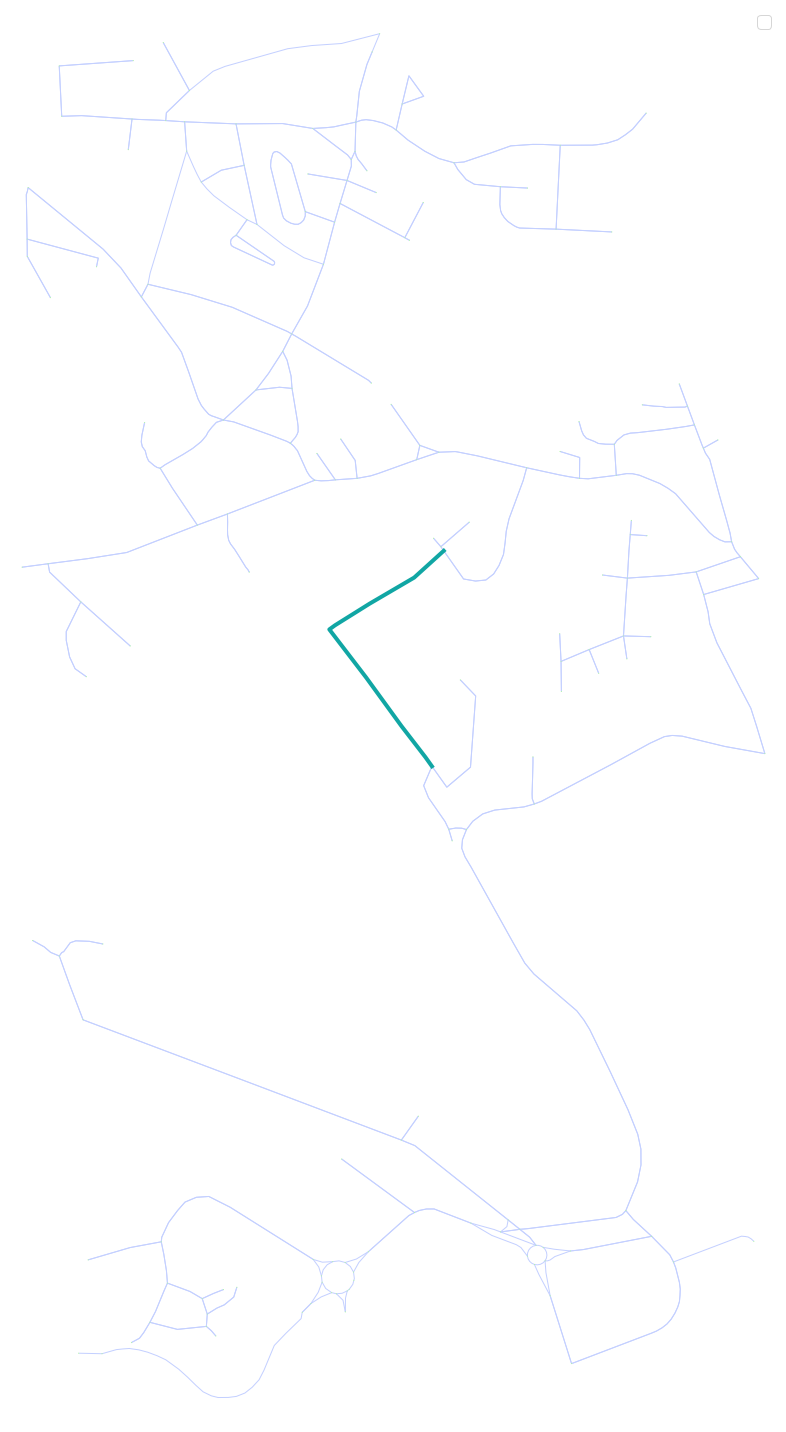

In [ ]:
# Plot 3rd road segement

x_min = 0
x_max = 0
y_min = 0
y_max = 0
bFirst = True

roadCoords = removeLineStringGeometry(portoEdges.loc[fiveLongestTime[2][0][0],'geometry'])

for i in roadCoords:
  tmpX = i[0]
  tmpY = i[1]
  xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

# Plot five most traversed road segments
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot([i[0] for i in roadCoords], [i[1] for i in roadCoords], color = '#11A6A4', linewidth=4)

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./mapPlots/5LargestTimeThird.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))

# Print Road Name
roadName = portoEdges.loc[fiveLongestTime[2][0][0], "name"]
print(roadName)

# Task 5: Plot top 5 road segments with largest average travelling time separately (4th)

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
No handles with labels found to put in legend.


   Duration 6.361536264419556 seconds
['Avenida Gustavo Eiffel', 'Avenida de Paiva Couceiro']


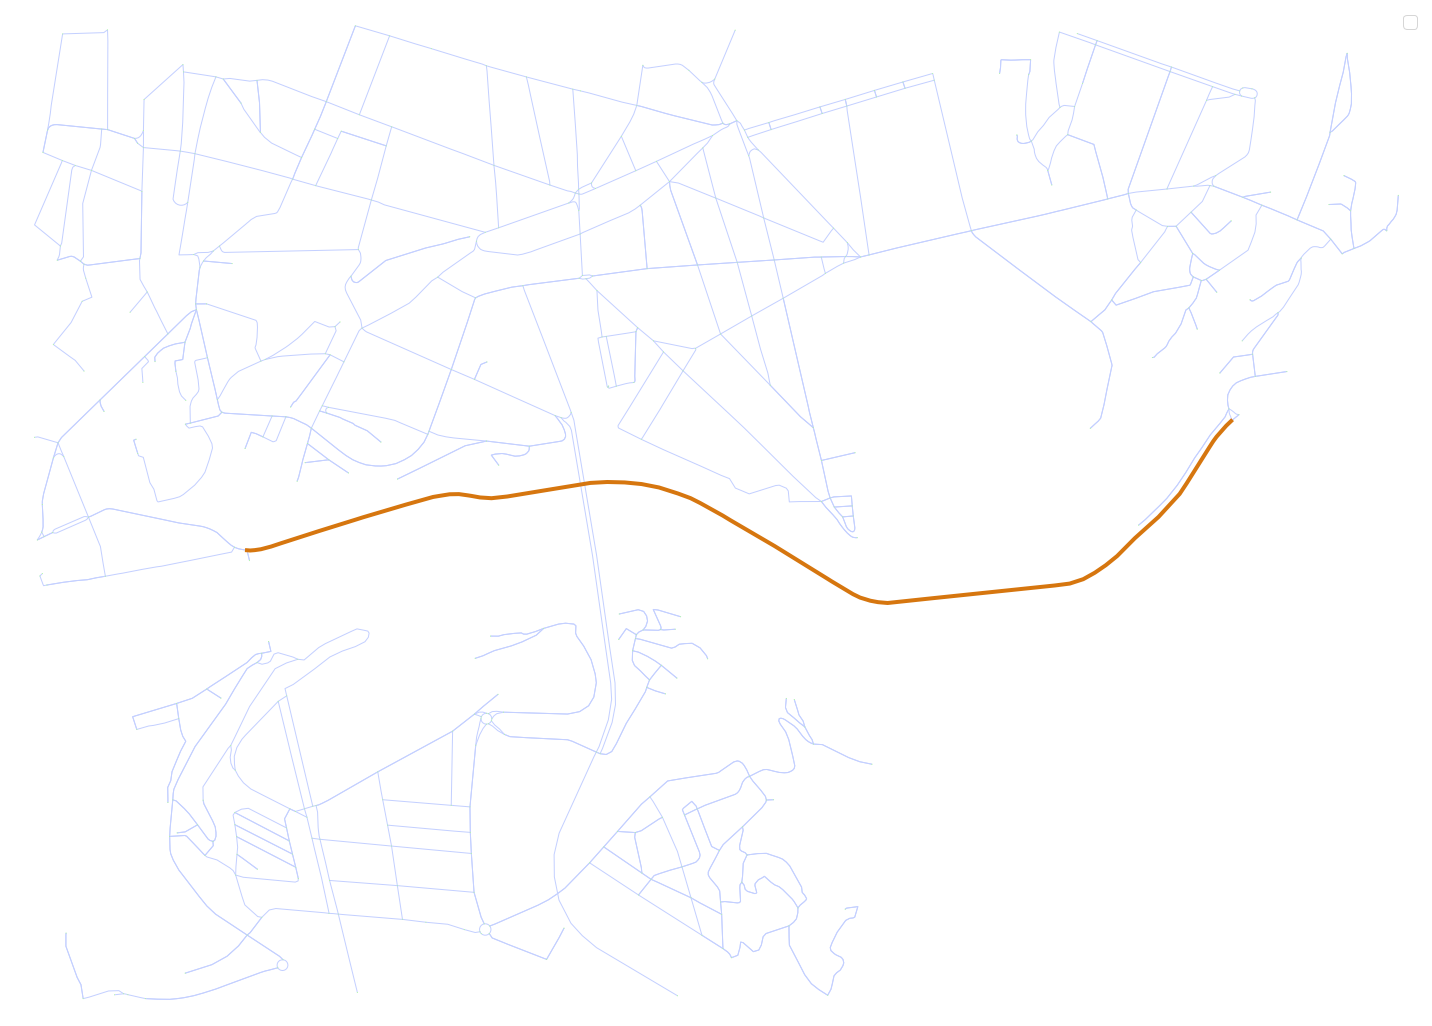

In [ ]:
# Plot 4th road segement

x_min = 0
x_max = 0
y_min = 0
y_max = 0
bFirst = True

roadCoords = removeLineStringGeometry(portoEdges.loc[fiveLongestTime[3][0][0],'geometry'])

for i in roadCoords:
  tmpX = i[0]
  tmpY = i[1]
  xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

# Plot five most traversed road segments
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot([i[0] for i in roadCoords], [i[1] for i in roadCoords], color = '#D6760F', linewidth=4)

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./mapPlots/5LargestTimeFourth.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))

# Print Road Name
roadName = portoEdges.loc[fiveLongestTime[3][0][0], "name"]
print(roadName)

# Task 5: Plot top 5 road segments with largest average travelling time separately (5th)

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
No handles with labels found to put in legend.


   Duration 6.050412654876709 seconds
Rua da Prelada


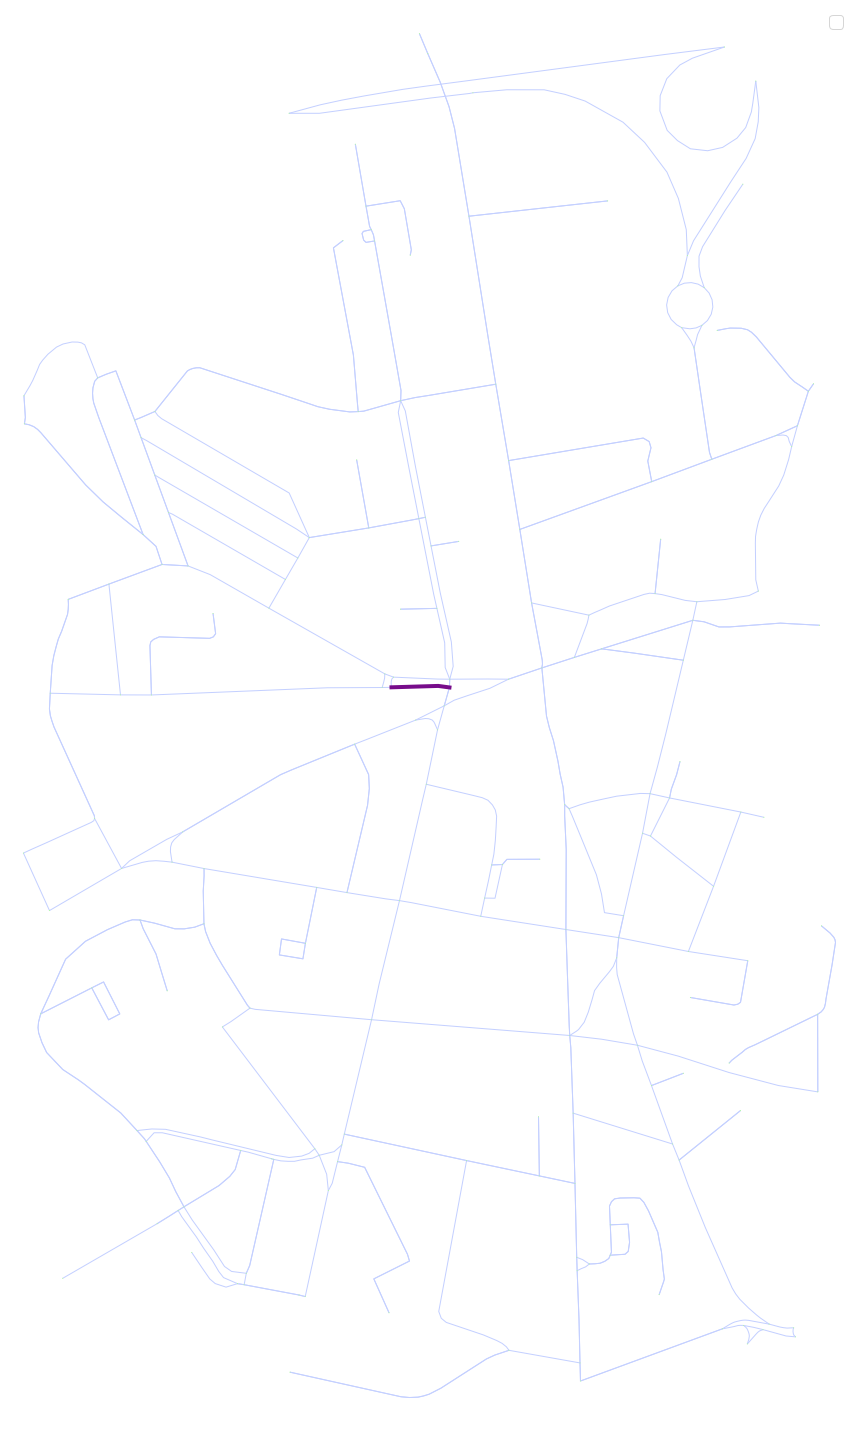

In [ ]:
# Plot 5th road segement

x_min = 0
x_max = 0
y_min = 0
y_max = 0
bFirst = True

roadCoords = removeLineStringGeometry(portoEdges.loc[fiveLongestTime[4][0][0],'geometry'])

for i in roadCoords:
  tmpX = i[0]
  tmpY = i[1]
  xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

# Plot five most traversed road segments
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot([i[0] for i in roadCoords], [i[1] for i in roadCoords], color = '#770C8A', linewidth=4)

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./mapPlots/5LargestTimeFifth.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))

# Print Road Name
roadName = portoEdges.loc[fiveLongestTime[4][0][0], "name"]
print(roadName)